## This notebook demonstrates the use of the pre-trained [Barlow Twins: Self-Supervised Learning via Redundancy Reduction](https://arxiv.org/abs/2103.03230) model on an unsupervised clustering problem.
## I use the CIFAR10 and STL10 training datasets to train a K-means model from the image embeddings and predict clusters for the test data. 
## Understandably, this yields worse results than the supervised problem itself, but hopefully we will see one predominant class in each cluster (10 classes->10 clusters). 


In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torchvision
from torchvision import datasets, models, transforms
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1
Torchvision Version:  0.9.1


# Step 1 - Load the data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


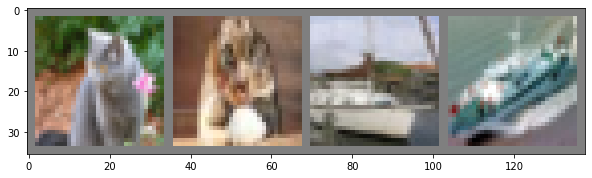

  cat   cat  ship  ship


In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# figure size in inches
rcParams['figure.figsize'] = 10,10
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Prepare the data for K-means

In [4]:
# load in the BarlowTwins model
barlowtwins_model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')

Using cache found in /Users/vladmarinescu/.cache/torch/hub/facebookresearch_barlowtwins_main


In [5]:
cols = [f"encoding_{i}" for i in range(1000)]# the model encoding is size 1000
label = "label"
training = pd.DataFrame(columns=cols+[label]) 
for inputs, labels in tqdm(trainloader):
    batch = pd.DataFrame(barlowtwins_model(inputs).detach().numpy(), columns=cols)
    batch[label] = labels
    training = training.append(batch,ignore_index=True)

training["class"] = training[label].apply(lambda x: classes[x])

100%|██████████| 50/50 [03:57<00:00,  4.76s/it]


In [6]:
testing = pd.DataFrame(columns=cols+[label]) 
for inputs, labels in tqdm(testloader):
    batch = pd.DataFrame(barlowtwins_model(inputs).detach().numpy(), columns=cols)
    batch[label] = labels
    testing = testing.append(batch,ignore_index=True)

testing["class"] = testing[label].apply(lambda x: classes[x])

100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


## We can look at the data in 2 dimensions. We don't really see any particular grouping which is indicative of the disappointing result we see later

<AxesSubplot:>

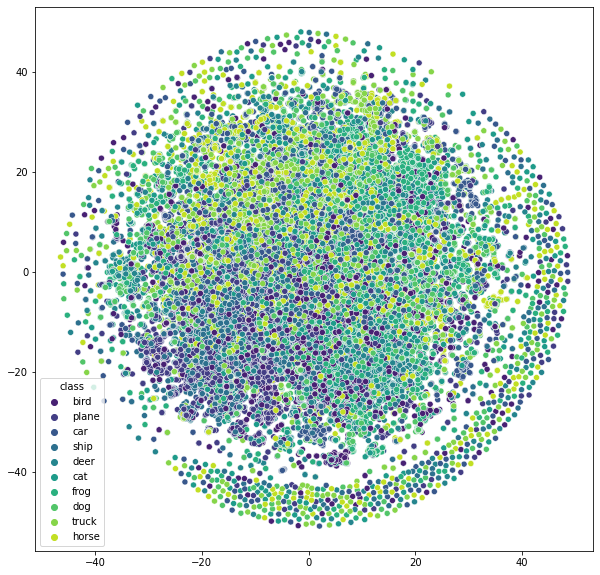

In [7]:
# TSNE plot
from sklearn.manifold import TSNE

transformed = TSNE(n_components=2,n_jobs=-1,random_state=42).fit_transform(training[cols])

sns.scatterplot(data=training, x=transformed[:, 0], y=transformed[:, 1], hue="class", palette="viridis")

<AxesSubplot:>

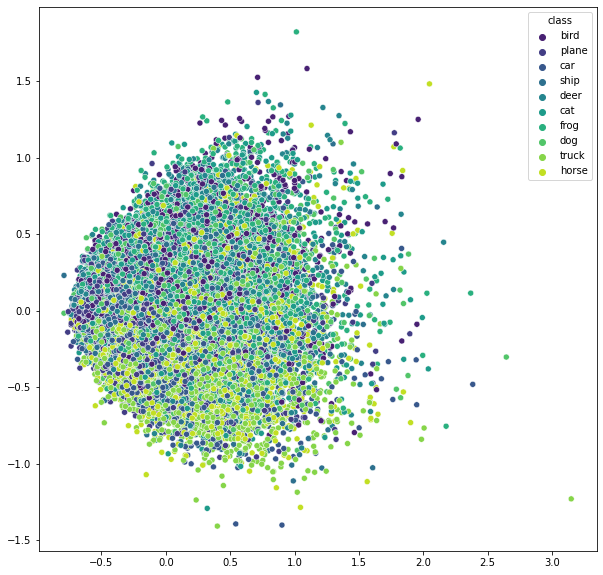

In [8]:
from sklearn.decomposition import PCA

transformed = PCA(n_components=2,svd_solver='full').fit_transform(training[cols])

sns.scatterplot(data=training, x=transformed[:, 0], y=transformed[:, 1], hue="class", palette="viridis")

# Now let's cluster the images

In [9]:
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns
k_mean = KMeans(n_clusters=10,n_init=50,random_state=1) # 10 clusters since we have 10 categories

In [10]:
k_mean.fit(training[cols])

KMeans(n_clusters=10, n_init=50, random_state=1)

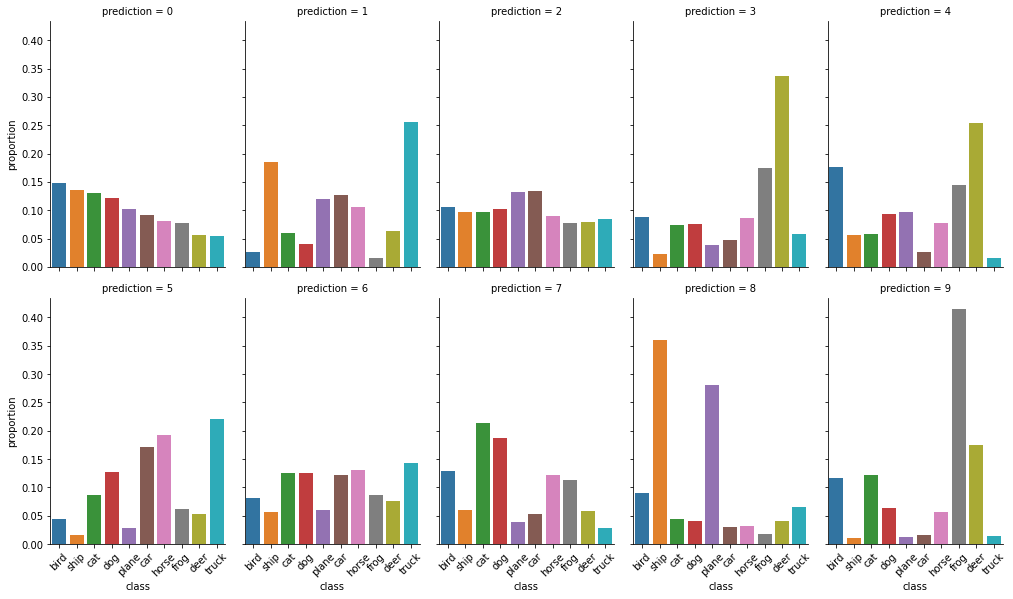

In [12]:
testing["prediction"] = k_mean.predict(testing[cols])

groups = testing.groupby(["prediction"])["class"].value_counts(normalize=True)
groups.name = "proportion"
groups = groups.reset_index()
chart = sns.catplot(col='prediction', y='proportion', x='class', data=groups,kind="bar",
                col_wrap=5, height=4, aspect=.7)
chart.set_xticklabels(rotation=45)

### As can be seen, there is no cluster where one category is particularly prominent, so although this has a visibly bad outcome, we can still measure the performance of the algorithm.
### We assign the cluster to the label that is most prominent (and we take out that category so each class has a cluster).

In [13]:
mapping = {}
sorted_groups = groups.sort_values("proportion",ascending=False).copy()
for i in range(groups["prediction"].nunique()):
    item = sorted_groups["proportion"].idxmax()
    prediction, cs =  sorted_groups.at[item,"prediction"], sorted_groups.at[item,"class"]
    mapping[prediction] = (classes.index(sorted_groups.at[item,"class"]),cs)
    sorted_groups = sorted_groups[(sorted_groups["prediction"]!=prediction) & (sorted_groups["class"]!=cs)]

In [14]:
mapping

{9: (6, 'frog'),
 8: (8, 'ship'),
 3: (4, 'deer'),
 1: (9, 'truck'),
 7: (3, 'cat'),
 5: (7, 'horse'),
 4: (2, 'bird'),
 2: (1, 'car'),
 6: (5, 'dog'),
 0: (0, 'plane')}

### Of course, here we don't get a completely fair view as prediction 1 is taken by Horse which is not the major class, but truck is more prominent in prediction 5

In [15]:
testing["mapped_prediction"] = testing["prediction"].apply(lambda x: mapping[x][0])

In [16]:
print(metrics.classification_report(testing["label"].astype(int), testing["mapped_prediction"]))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10      1000
           1       0.13      0.41      0.20      1000
           2       0.18      0.14      0.15      1000
           3       0.21      0.15      0.18      1000
           4       0.34      0.17      0.23      1000
           5       0.12      0.07      0.09      1000
           6       0.41      0.26      0.32      1000
           7       0.19      0.22      0.21      1000
           8       0.36      0.23      0.28      1000
           9       0.26      0.24      0.25      1000

    accuracy                           0.20     10000
   macro avg       0.23      0.20      0.20     10000
weighted avg       0.23      0.20      0.20     10000



### And as expected: a bad performance

### What if the details in the images are too small for the model to visualise ? Some pictures are very pixelated at 32x32. Can it do better with larger images ? 

## Looking at the STL10 dataset (where images are higher resolution)

In [48]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1000

stl_trainset = torchvision.datasets.STL10(root='./stl_data', split='train',
                                        download=True, transform=transform)
stl_trainloader = torch.utils.data.DataLoader(stl_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

stl_testset = torchvision.datasets.STL10(root='./stl_data', split='test',
                                       download=True, transform=transform)
stl_testloader = torch.utils.data.DataLoader(stl_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

stl_classes = ('plane', 'bird', 'car', 'cat',
           'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


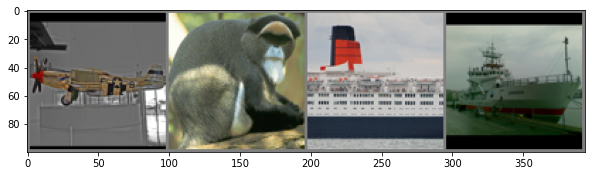

plane monkey  ship  ship


In [58]:

# get some random training images
dataiter = iter(stl_trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % stl_classes[labels[j]] for j in range(4)))

In [59]:
cols = [f"encoding_{i}" for i in range(1000)]# the model encoding is size 1000
label = "label"
stl_training = pd.DataFrame(columns=cols+[label]) 
for inputs, labels in tqdm(stl_trainloader):
    batch = pd.DataFrame(barlowtwins_model(inputs).detach().numpy(), columns=cols)
    batch[label] = labels
    stl_training = stl_training.append(batch,ignore_index=True)

stl_training["class"] = stl_training[label].apply(lambda x: stl_classes[x])

100%|██████████| 5/5 [03:28<00:00, 41.71s/it]


In [60]:
stl_testing = pd.DataFrame(columns=cols+[label]) 
for inputs, labels in tqdm(stl_testloader):
    batch = pd.DataFrame(barlowtwins_model(inputs).detach().numpy(), columns=cols)
    batch[label] = labels
    stl_testing = stl_testing.append(batch,ignore_index=True)

stl_testing["class"] = stl_testing[label].apply(lambda x: stl_classes[x])

100%|██████████| 8/8 [05:30<00:00, 41.35s/it]


## Clustering, again

In [61]:
stl_k_mean = KMeans(n_clusters=10,n_init=50,random_state=1) # 10 clusters since we have 10 categories

In [62]:
stl_k_mean.fit(stl_training[cols])

KMeans(n_clusters=10, n_init=50, random_state=1)

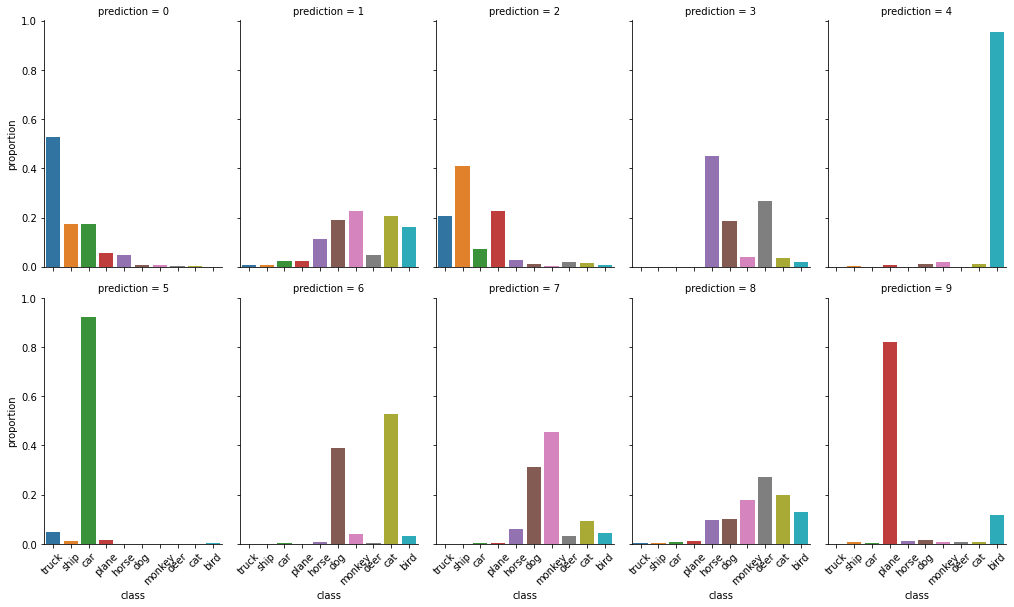

In [68]:
stl_testing["prediction"] = stl_k_mean.predict(stl_testing[cols])

stl_groups = stl_testing.groupby(["prediction"])["class"].value_counts(normalize=True)
stl_groups.name = "proportion"
stl_groups = stl_groups.reset_index()
chart = sns.catplot(col='prediction', y='proportion', x='class', data=stl_groups,kind="bar",
                col_wrap=5, height=4, aspect=.7)
chart.set_xticklabels(rotation=45)

### A clear improvement can be seen from the CIFAR10 dataset with 9-plane, 5-car and 4-bird

In [69]:
stl_mapping = {}
stl_sorted_groups = stl_groups.sort_values("proportion",ascending=False).copy()
for i in range(stl_groups["prediction"].nunique()):
    item = stl_sorted_groups["proportion"].idxmax()
    prediction, cs =  stl_sorted_groups.at[item,"prediction"], stl_sorted_groups.at[item,"class"]
    stl_mapping[prediction] = (stl_classes.index(stl_sorted_groups.at[item,"class"]),cs)
    stl_sorted_groups = stl_sorted_groups[(stl_sorted_groups["prediction"]!=prediction) & (stl_sorted_groups["class"]!=cs)]

In [71]:
stl_mapping

{4: (1, 'bird'),
 5: (2, 'car'),
 9: (0, 'plane'),
 0: (9, 'truck'),
 6: (3, 'cat'),
 7: (7, 'monkey'),
 3: (6, 'horse'),
 2: (8, 'ship'),
 8: (4, 'deer'),
 1: (5, 'dog')}

In [74]:
stl_testing["mapped_prediction"] = stl_testing["prediction"].apply(lambda x: stl_mapping[x][0])

In [75]:
print(metrics.classification_report(stl_testing["label"].astype(int), stl_testing["mapped_prediction"]))

              precision    recall  f1-score   support

           0       0.82      0.43      0.57       800
           1       0.95      0.38      0.55       800
           2       0.92      0.64      0.75       800
           3       0.53      0.17      0.26       800
           4       0.27      0.58      0.37       800
           5       0.19      0.25      0.21       800
           6       0.45      0.50      0.47       800
           7       0.46      0.24      0.31       800
           8       0.41      0.79      0.54       800
           9       0.53      0.56      0.54       800

    accuracy                           0.45      8000
   macro avg       0.55      0.45      0.46      8000
weighted avg       0.55      0.45      0.46      8000



### A much better result, but not great either. 
#### Other items to consider
1. The model does very well on the classfication side of the problem, perhaps fine-tuning another layer before using the embeddings will yield better results. 
2. The embeddings may still be useful in finding similar images quickly. I tackle this problem in my Annoy&BarlowTwins Notebook. 